# Data preprocessing
- Read Preparation
- Exploratory Data Analysis (EDA)
- Feature Engineering

In [2]:
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm
#BASE = '../data/'

## Data Preparation

In [3]:
census = pd.read_csv("D:\学习\Kaggle\GoDaddy\data\census_starter.csv")
# generate the graph for county_adjacency
county_adjacency = pd.read_csv("D:\学习\Kaggle\GoDaddy\data\county_adjacency.txt", encoding='latin-1', sep="\t", names=["county", "cfips", "neighbor", "neighbor_cfips"])

train = pd.read_csv("D:/学习/Kaggle/GoDaddy/data/train.csv")
test = pd.read_csv("D:/学习/Kaggle/GoDaddy/data/test.csv")
# download the submission sheet.
sub = pd.read_csv("D:\学习\Kaggle\GoDaddy\data\sample_submission.csv")
print(train.shape, test.shape, sub.shape)

cfips_list = train['cfips'].unique()
# process the raw data and merge the data
train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values(['cfips', 'row_id']).reset_index(drop=True)

raw['first_day_of_month'] = pd.to_datetime(raw['first_day_of_month'])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
raw["year"] = raw["first_day_of_month"].dt.year
raw["month"] = raw["first_day_of_month"].dt.month
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]
raw.tail(20)
raw.head(5)
raw.head(5)

(122265, 7) (25080, 3) (25080, 2)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0


In [4]:
train.info

<bound method DataFrame.info of                   row_id  cfips             county    state  \
0        1001_2019-08-01   1001     Autauga County  Alabama   
1        1003_2019-08-01   1003     Baldwin County  Alabama   
2        1005_2019-08-01   1005     Barbour County  Alabama   
3        1007_2019-08-01   1007        Bibb County  Alabama   
4        1009_2019-08-01   1009      Blount County  Alabama   
...                  ...    ...                ...      ...   
122260  56037_2022-10-01  56037  Sweetwater County  Wyoming   
122261  56039_2022-10-01  56039       Teton County  Wyoming   
122262  56041_2022-10-01  56041       Uinta County  Wyoming   
122263  56043_2022-10-01  56043    Washakie County  Wyoming   
122264  56045_2022-10-01  56045      Weston County  Wyoming   

       first_day_of_month  microbusiness_density  active  istest  
0                2019/8/1               3.007682    1249       0  
1                2019/8/1               7.239156   11464       0  
2         

In [19]:
raw.count()

row_id                   147345
cfips                    147345
county                   147345
state                    147345
first_day_of_month       147345
microbusiness_density    122265
active                   122265
istest                   147345
year                     147345
month                    147345
dcount                   147345
county_i                 147345
state_i                  147345
dtype: int64

In [52]:
train.isnull().sum()

row_id                   0
cfips                    0
county                   0
state                    0
first_day_of_month       0
microbusiness_density    0
active                   0
istest                   0
dtype: int64

In [5]:
# descriptive analysis
raw.describe()

,cfips,microbusiness_density,active,istest,year,month,dcount,county_i,state_i
count,147345.00000,122265.000000,1.222650e+05,147345.000000,147345.000000,147345.000000,147345.000000,147345.000000,147345.000000
mean,30376.03764,3.817671,6.442858e+03,0.170213,2021.042553,6.489362,23.000000,1567.000000,26.229665
std,15143.49818,4.991087,3.304001e+04,0.375821,1.202085,3.487816,13.564706,904.999572,14.253984
min,1001.00000,0.000000,0.000000e+00,0.000000,2019.000000,1.000000,0.000000,0.000000,0.000000
25%,18177.00000,1.639344,1.450000e+02,0.000000,2020.000000,3.000000,11.000000,783.000000,14.000000
50%,29173.00000,2.586543,4.880000e+02,0.000000,2021.000000,6.000000,23.000000,1567.000000,25.000000
75%,45077.00000,4.519231,2.124000e+03,0.000000,2022.000000,10.000000,35.000000,2351.000000,40.000000
max,56045.00000,284.340030,1.167744e+06,1.000000,2023.000000,12.000000,46.000000,3134.000000,50.000000


## Data Analysis

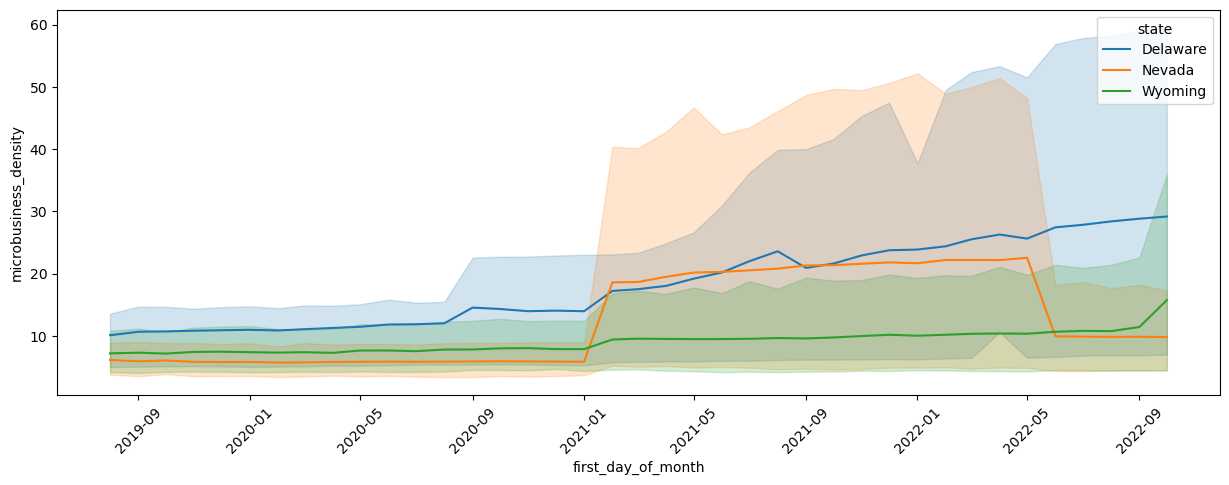

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
raw['year_month'] = raw['year']+raw['month']
plt.figure(figsize=(15, 5))
sns.lineplot(data=raw[raw['state'].isin(['Nevada','Wyoming','Delaware'])],x='first_day_of_month',y='microbusiness_density',hue='state')
#sns.lineplot(data=raw,x='year_month',y='microbusiness_density',hue='state')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

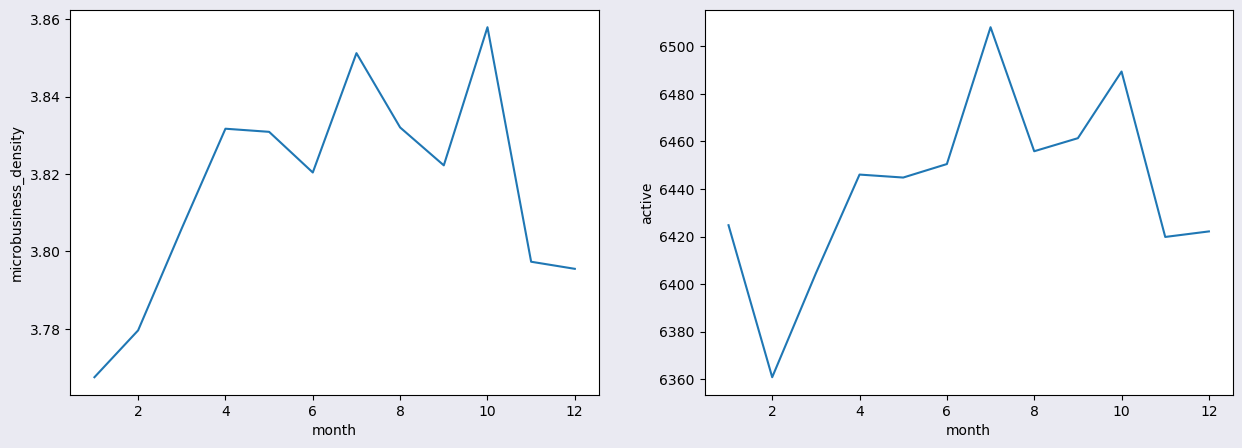

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(15,5), facecolor='#EAEAF2')
sns.lineplot(data=raw.groupby('month').mean(),x='month',y='microbusiness_density',ax=axes[0])
sns.lineplot(data=raw.groupby('month').mean(),x='month',y='active',ax=axes[1])
plt.show()

In [21]:
sort_std=raw.groupby(['state']).describe()['microbusiness_density'].sort_values('std').index
each_state=raw.groupby(['state']).describe()['microbusiness_density'].sort_values('std')
each_state

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
District of Columbia,39.0,13.508989,0.294487,12.787801,13.269190,13.551914,13.697423,14.005946
Rhode Island,195.0,6.985363,1.207692,4.969075,6.032383,7.264053,8.120277,8.660382
West Virginia,2145.0,1.855457,1.241438,0.360211,0.878539,1.453722,2.542662,7.043378
Arkansas,2925.0,1.998925,1.497099,0.247328,0.974982,1.531890,2.445632,16.291933
Kansas,4095.0,2.463091,1.532490,0.562430,1.576070,2.148502,2.800141,14.035515
Mississippi,3198.0,1.696296,1.539697,0.000000,0.863192,1.305429,1.952426,14.852497
Alabama,2613.0,2.223274,1.584220,0.438305,1.202177,1.639288,2.709124,8.573463
Kentucky,4680.0,2.077160,1.731339,0.224027,0.953756,1.593625,2.662017,14.448168
Ohio,3432.0,3.034945,1.765796,0.637639,1.686132,2.482716,3.726996,9.845983


In [23]:
raw = raw.loc[~((raw['microbusiness_density'] == 0))]

In [ ]:
# 从空间上找到outlier
outliers = []
cnt = 0
for o in tqdm(raw.cfips.unique()):
    indices = (raw['cfips']==o)
    tmp = raw.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density.values.copy()
# 从第三个开始取平均值，每个
    for i in range(25, 2, -1):
        thr = 0.20*np.mean(var[:i])
        difa = abs(var[i] - var[i-1])
        if (difa >= thr):
            var[:i] *= (var[i]/var[i-1])
            outliers.append(o)
            cnt += 1
    var[0] = var[1] * 0.99
    raw.loc[indices, 'microbusiness_density'] = var
    
outliers = np.unique(outliers)

In [25]:
outliers = pd.DataFrame(outliers)
outliers.head()

,0
0,1013
1,1035
2,1037
3,1045
4,1057


<AxesSubplot:xlabel='dcount'>

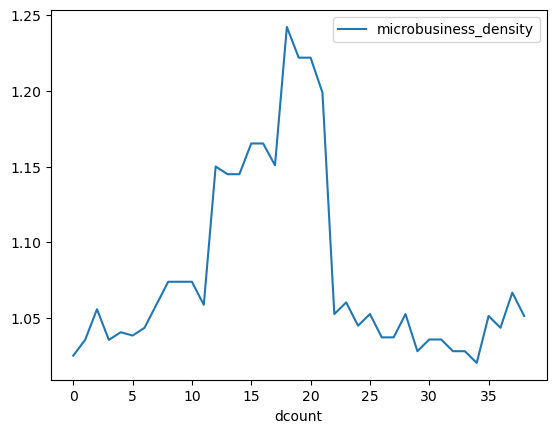

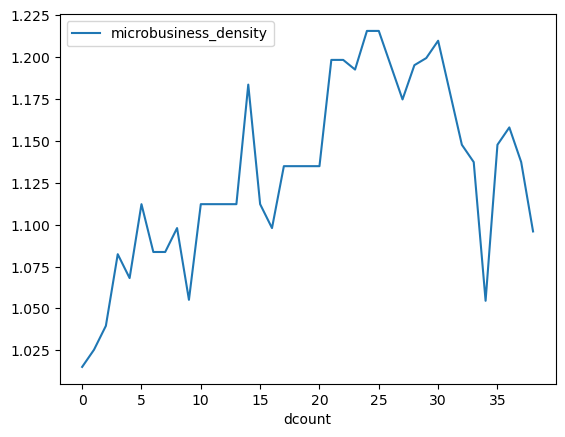

In [26]:
raw.loc[raw.cfips == 1013].plot(x='dcount', y='microbusiness_density')
raw.loc[raw.cfips == 1035].plot(x='dcount', y='microbusiness_density')

In [28]:
raw['target'] = raw.groupby('cfips')['microbusiness_density'].shift(-1)
raw['target'] = raw['target']/raw['microbusiness_density'] - 1

raw.loc[raw['cfips']==28055, 'target'] = 0.0
raw.loc[raw['cfips']==48269, 'target'] = 0.0

raw.iloc[-20:,:20]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,year_month,mbd_lag_1,dif,target
147325,56045_2021-11-01,56045,Weston County,Wyoming,2021-11-01,1.760374,98.0,0,2021,11,27,3134,50,2032,1.670559,0.053763,0.020408
147326,56045_2021-12-01,56045,Weston County,Wyoming,2021-12-01,1.796300,100.0,0,2021,12,28,3134,50,2033,1.760374,0.020408,-0.025949
147327,56045_2022-01-01,56045,Weston County,Wyoming,2022-01-01,1.749688,98.0,0,2022,1,29,3134,50,2023,1.796300,0.025949,0.000000
147328,56045_2022-02-01,56045,Weston County,Wyoming,2022-02-01,1.749688,98.0,0,2022,2,30,3134,50,2024,1.749688,0.000000,0.010204
147329,56045_2022-03-01,56045,Weston County,Wyoming,2022-03-01,1.767542,99.0,0,2022,3,31,3134,50,2025,1.749688,0.010204,0.000000
147330,56045_2022-04-01,56045,Weston County,Wyoming,2022-04-01,1.767542,99.0,0,2022,4,32,3134,50,2026,1.767542,0.000000,0.020202
147331,56045_2022-05-01,56045,Weston County,Wyoming,2022-05-01,1.803249,101.0,0,2022,5,33,3134,50,2027,1.767542,0.020202,0.000000
147332,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101.0,0,2022,6,34,3134,50,2028,1.803249,0.000000,0.000000
147333,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101.0,0,2022,7,35,3134,50,2029,1.803249,0.000000,-0.009901
147334,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100.0,0,2022,8,36,3134,50,2030,1.803249,0.009901,0.000000


<AxesSubplot:>

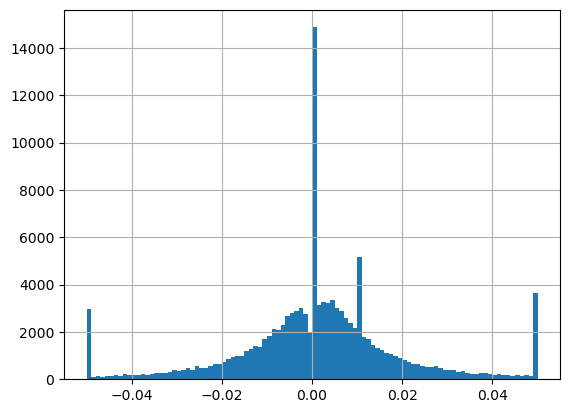

In [29]:
raw['target'].clip(-0.05, 0.05).hist(bins=100)

<AxesSubplot:>

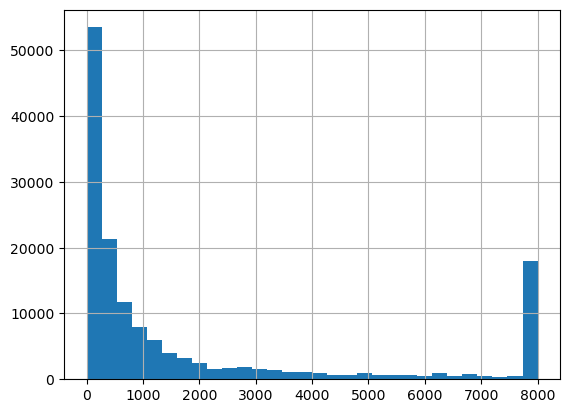

In [30]:
raw['lastactive'] = raw.groupby('cfips')['active'].transform('last')

dt = raw.loc[raw.dcount==28].groupby('cfips')['microbusiness_density'].agg('last')
raw['lasttarget'] = raw['cfips'].map(dt)

raw['lastactive'].clip(0, 8000).hist(bins=30)

## Feature Engineering

In [31]:
# transform the dataset into a dictionary, and find the adjacent county code. 
adjacency_dict = dict()
temp = 0
for index, row in county_adjacency.iterrows():
    if row.notnull()['cfips']:
        temp = row['cfips']
        adjacency_dict[temp] = []
    else:
        adjacency_dict[temp].append(row['neighbor_cfips'])
adjacency_dict

{1001.0: [1021, 1047, 1051, 1085, 1101],
 1003.0: [1025, 1053, 1097, 1099, 1129, 12033],
 1005.0: [1011, 1045, 1067, 1109, 1113, 13061, 13239, 13259],
 1007.0: [1021, 1065, 1073, 1105, 1117, 1125],
 1009.0: [1043, 1055, 1073, 1095, 1115, 1127],
 1011.0: [1011, 1087, 1101, 1109, 1113],
 1013.0: [1035, 1039, 1041, 1085, 1099, 1131],
 1015.0: [1019, 1029, 1055, 1115, 1121],
 1017.0: [1081, 1111, 1123, 13145, 13285],
 1019.0: [1019, 1029, 1049, 1055, 13055, 13115, 13233],
 1021.0: [1007, 1021, 1037, 1047, 1051, 1105, 1117],
 1023.0: [1025, 1091, 1119, 1129, 28023, 28075, 28153],
 1025.0: [1023, 1025, 1091, 1099, 1129, 1131],
 1027.0: [1029, 1037, 1111, 1121, 1123],
 1029.0: [1019, 1027, 1029, 1111, 1121, 13045, 13143, 13233],
 1031.0: [1039, 1041, 1045, 1061, 1109],
 1033.0: [1059, 1077, 1079, 28141],
 1035.0: [1035, 1039, 1053, 1099],
 1037.0: [1027, 1037, 1051, 1117, 1121, 1123],
 1039.0: [1031, 1035, 1039, 1041, 1053, 1061, 12091, 12131],
 1041.0: [1031, 1039, 1041, 1085, 1101, 1109],
 

In [32]:
import copy

# remove the values not in cfips_list
temp_list = copy.deepcopy(adjacency_dict)
for var in temp_list.keys():
    if int(var) not in cfips_list:
        del adjacency_dict[var]
        
for var in adjacency_dict.keys():
    adjacency_dict[var] = [x for x in adjacency_dict[var] if x in cfips_list]

In [33]:
# 转化数据类型
for key, value in adjacency_dict.items():
    key = int(key)
    value = [int(i) for i in value]

mbd represents the microbusiness_density

act represents the active

In [34]:
def build_features(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    feats = []
    for lag in range(1, lags):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
        
    lag = 1
    for window in [2, 4, 6]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())        
        #raw[f'mbd_rollmea{window}_{lag}'] = raw[f'mbd_lag_{lag}'] - raw[f'mbd_rollmea{window}_{lag}']
        feats.append(f'mbd_rollmea{window}_{lag}')
        
    # add neighbor density average
    neighbor_average = []
    for ind, row in raw.iterrows():
        cfip = int(row['cfips'])
        first_day_of_month = row['first_day_of_month']
        tmp = []
        for var in adjacency_dict[cfip]:
            df = raw[(raw['cfips']==var) & (raw['first_day_of_month']==first_day_of_month)]
            tmp.append(df['active'])
        if tmp == []:
            neighbor_average.append(0)
        else:
            neighbor_average.append(np.mean(tmp))
        
    raw['neighbor_average'] = neighbor_average
    feats.append('neighbor_average')
        
    return raw, feats

In [35]:
# Build Features based in lag of target
raw, feats = build_features(raw, 'target', 'active', lags = 4)
features = ['state_i']
features += feats
print(features)
raw.loc[raw.dcount==38, features].head(20)

d:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


['state_i', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1', 'neighbor_average']


,state_i,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_rollmea2_1,mbd_rollmea4_1,mbd_rollmea6_1,neighbor_average
38,0,0.006152,9.0,0.005498,17.0,-0.004107,11.0,0.011650,0.034969,0.027467,2297.2
85,0,0.002170,31.0,-0.017601,-225.0,-0.009601,-366.0,-0.015431,-0.017278,0.049618,5192.0
132,0,0.020921,5.0,0.008439,7.0,-0.016597,3.0,0.029359,0.033948,0.033966,351.25
179,0,-0.021367,-5.0,0.017391,-1.0,-0.025424,-7.0,-0.003976,0.010248,0.028286,8840.333333
226,0,-0.010949,-9.0,0.008589,-2.0,0.002460,0.0,-0.002360,0.033137,0.038372,6981.333333
273,0,0.012987,1.0,0.013158,2.0,0.013333,3.0,0.026145,0.052992,0.080770,2059.6
320,0,0.009036,3.0,0.027864,12.0,0.031949,22.0,0.036900,0.098454,0.171279,181.5
367,0,-0.003180,-8.0,0.007609,11.0,0.002006,16.0,0.004429,0.027747,0.034010,1148.8
414,0,-0.040201,-16.0,-0.012407,-21.0,-0.017073,-28.0,-0.052608,-0.015697,-0.023285,2265.2
461,0,-0.012605,-3.0,0.000000,-3.0,-0.008333,-5.0,-0.012605,0.000338,-0.098884,1033.714286


In [49]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pct_bb_2017            3142 non-null   float64
 1   pct_bb_2018            3142 non-null   float64
 2   pct_bb_2019            3142 non-null   float64
 3   pct_bb_2020            3141 non-null   float64
 4   pct_bb_2021            3141 non-null   float64
 5   cfips                  3142 non-null   int64  
 6   pct_college_2017       3142 non-null   float64
 7   pct_college_2018       3142 non-null   float64
 8   pct_college_2019       3142 non-null   float64
 9   pct_college_2020       3141 non-null   float64
 10  pct_college_2021       3141 non-null   float64
 11  pct_foreign_born_2017  3142 non-null   float64
 12  pct_foreign_born_2018  3142 non-null   float64
 13  pct_foreign_born_2019  3142 non-null   float64
 14  pct_foreign_born_2020  3141 non-null   float64
 15  pct_

In [58]:
census.isnull().sum()

pct_bb_2017              0
pct_bb_2018              0
pct_bb_2019              0
pct_bb_2020              1
pct_bb_2021              1
cfips                    0
pct_college_2017         0
pct_college_2018         0
pct_college_2019         0
pct_college_2020         1
pct_college_2021         1
pct_foreign_born_2017    0
pct_foreign_born_2018    0
pct_foreign_born_2019    0
pct_foreign_born_2020    1
pct_foreign_born_2021    1
pct_it_workers_2017      0
pct_it_workers_2018      1
pct_it_workers_2019      0
pct_it_workers_2020      1
pct_it_workers_2021      1
median_hh_inc_2017       0
median_hh_inc_2018       0
median_hh_inc_2019       0
median_hh_inc_2020       0
median_hh_inc_2021       0
dtype: int64

In [62]:
census['median_hh_inc_2017'] = census['median_hh_inc_2017'].fillna(np.mean(census['median_hh_inc_2017']))
census['median_hh_inc_2018'] = census['median_hh_inc_2018'].fillna(np.mean(census['median_hh_inc_2018']))
census['median_hh_inc_2019'] = census['median_hh_inc_2019'].fillna(np.mean(census['median_hh_inc_2019']))
census['median_hh_inc_2020'] = census['median_hh_inc_2020'].fillna(np.mean(census['median_hh_inc_2020']))
census['median_hh_inc_2021'] = census['median_hh_inc_2021'].fillna(np.mean(census['median_hh_inc_2021']))

In [ ]:
census['pct_bb_2020'] = census['pct_bb_2020'].fillna(np.mean(census['pct_bb_2020']))
census['pct_bb_2021'] = census['pct_bb_2021'].fillna(np.mean(census['pct_bb_2021']))
census['pct_college_2020'] = census['pct_college_2020'].fillna(np.mean(census['pct_college_2020']))
census['pct_college_2021'] = census['pct_college_2021'].fillna(np.mean(census['pct_college_2021']))


In [63]:
pct_bb = []
pct_college = []
pct_foreign_born = []
pct_it_workers = []
median_hh_inc = []

for ind, row in raw.iterrows():
    year = '2021' if row['year'] == 2022 or row['year'] == 2023 else str(row['year'])
    pct_bb.append(int(census.loc[census['cfips']==row['cfips'], 'pct_bb_'+year]))
    pct_college.append(int(census.loc[census['cfips']==row['cfips'], 'pct_college_'+year]))
    pct_foreign_born.append(int(census.loc[census['cfips']==row['cfips'], 'pct_foreign_born_'+year]))
    pct_it_workers.append(int(census.loc[census['cfips']==row['cfips'], 'pct_it_workers_'+year]))
    median_hh_inc.append(int(census.loc[census['cfips']==row['cfips'], 'median_hh_inc_'+year]))

In [ ]:
raw['pct_bb'] = pct_bb
raw['pct_college'] = pct_college
raw['pct_foreign_born'] = pct_foreign_born
raw['pct_it_workers'] = pct_it_workers
raw['median_hh_inc'] = median_hh_inc

raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,...,act_lag_3,mbd_rollmea2_1,mbd_rollmea4_1,mbd_rollmea6_1,neighbor_average,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,2.856021,1249.0,0,2019,8,...,NaN,NaN,NaN,NaN,2157.8,80,16,2,0,58731
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,...,NaN,0.010101,0.010101,0.010101,2161.6,80,16,2,0,58731
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,...,NaN,0.069366,0.069366,0.069366,2158.4,80,16,2,0,58731
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,...,-6.0,0.038777,0.048878,0.048878,2150.0,80,16,2,0,58731
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,...,45.0,-0.020489,0.048878,0.048878,2215.4,80,16,2,0,58731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,...,NaN,NaN,NaN,0.000000,NaN,81,13,1,0,65566
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,...,NaN,NaN,NaN,0.000000,NaN,81,13,1,0,65566
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,...,NaN,NaN,NaN,NaN,NaN,81,13,1,0,65566
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,...,NaN,NaN,NaN,NaN,NaN,81,13,1,0,65566


In [ ]:
features += ['pct_bb', 'pct_college', 'pct_foreign_born', 'pct_it_workers', 'median_hh_inc']

In [ ]:
# save the data
raw.to_csv("D:/学习/机器学习/机器学习大作业/preprocessing.csv", index=False)